# Getting started with Spystats
## Tutorial 1: Correlation functions and Simulations
The following tutorial gives an introduction on how to instantiate variogram objects with a theoretical model.
The examples used were Matern models explained in Chapter 3 of Model-Based Geostatistics (Diggle, Ribeiro, 2007). Spystats can be a Python alternative to the popular R package geoR.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/')
import django
django.setup()
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')


## Importing modules and functions

In [2]:
from spystats import tools
from scipy.special import logit,expit
from scipy.stats import bernoulli,poisson

## Computation

Here we will show how to plot the standard correlation functions. Currently `spystats.tools` have implemented the following models:
    * Matern Model  tools.MaternVariogram()
    * Exponential Model  tools.ExponentialVariogram()
    * Gaussian Model  tools.GaussianVariogram()
    * Spherical Model  tools.SphericalVariogram()
    * Whittle Model  tools.WhittleVariogram()
    
We will plot a function similar to the figure 3.2 (Diggle and Ribeiro,2007)

In [3]:
## Create the domain X
x = np.linspace(0,1,101)

In [4]:
m1 = tools.MaternVariogram(sill=1,range_a=0.25,kappa=0.5)
m2 = tools.MaternVariogram(sill=1,range_a=0.16,kappa=1.5)
m3 = tools.MaternVariogram(sill=1,range_a=0.13,kappa=2.5)

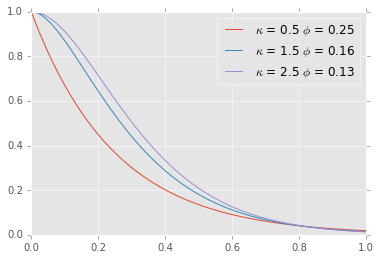

In [5]:
plt.plot(x,m1.corr_f(x))
plt.plot(x,m2.corr_f(x))
plt.plot(x,m3.corr_f(x))
plt.legend(['$\kappa$ = 0.5 $\phi$ = 0.25' ,'$\kappa$ = 1.5 $\phi$ = 0.16','$\kappa$ = 2.5 $\phi$ = 0.13'])

# Gaussian Process simulations
The next examples are to demonstrate how to simulate a Gaussian Random Field.

In [6]:
#We need to create a domain now for two dimensions.
grid = tools.createGrid()

## Apply the simualtion to all the models
%time s = map(lambda m : tools.simulateGaussianRandomField(m,grid,random_seed=12345),[m1,m2,m3])

CPU times: user 1min, sys: 1.5 s, total: 1min 2s
Wall time: 22.5 s


## Matern simulation for $\kappa$ = 0.5 and  $\phi$ = 0.25

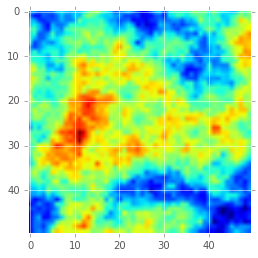

In [7]:
plt.imshow(s[0],interpolation=None)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

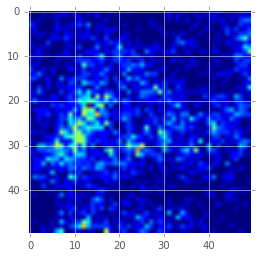

In [8]:
plt.imshow(poisson.rvs(np.exp(s[0]),0))

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

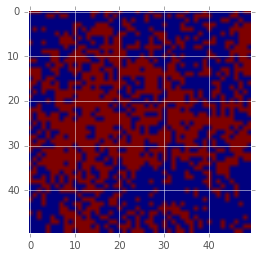

In [9]:
plt.imshow(bernoulli.rvs(expit(s[0]),1))

## Matern simulation for $\kappa$ = 1.5 $\phi$ = 0.16

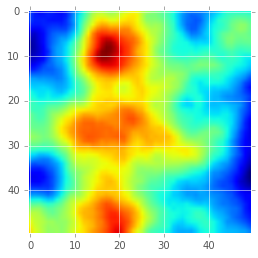

In [10]:
plt.imshow(s[1],interpolation=None)


### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

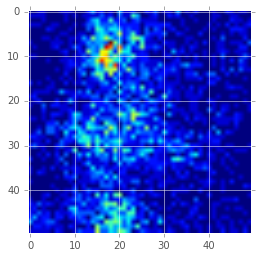

In [11]:
plt.imshow(poisson.rvs(np.exp(s[1]),0))

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

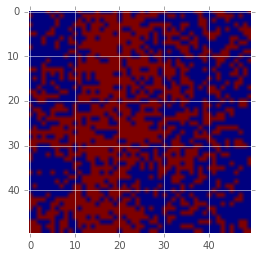

In [12]:
plt.imshow(bernoulli.rvs(expit(s[1]),0))

## Matern simulation for $\kappa$ = 2.5 $\phi$ = 0.13

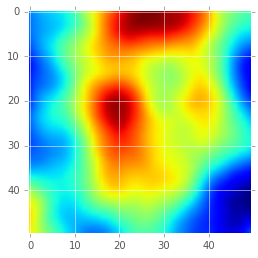

In [13]:
plt.imshow(s[2],interpolation=None)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

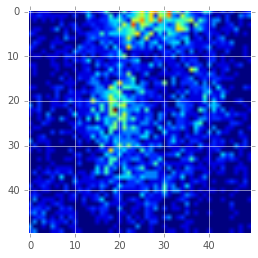

In [14]:
plt.imshow(poisson.rvs(np.exp(s[2]),1))

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

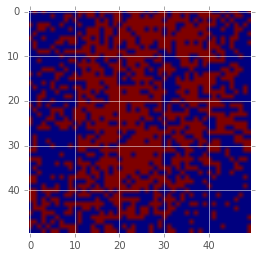

In [15]:
plt.imshow(bernoulli.rvs(expit(s[2]),0))

## Example to use anisotropy.
First thing needed a rotation matrix. Here I'm using the formulas given by Diggle and Ribeiro (2007) in section 3.7.

In [16]:
phi_A = (np.pi / 3.0)
#phi_A = 0.0
phi_R = 4.0
a = np.array([[np.cos(phi_A), -np.sin(phi_A)],[np.sin(phi_A),np.cos(phi_A)]])
b = np.array([[1, 0],[0,1.0 / phi_R]])

In [17]:
A = np.matmul(a,b)

In [18]:
new_coords = np.dot(grid[['Lon','Lat']].values,A)
n = len(new_coords)
nc = pd.DataFrame({'nLon':new_coords[:,0],'nLat':new_coords[:,1],'Y': np.zeros(n)})
nc = tools.toGeoDataFrame(nc,'nLon','nLat')

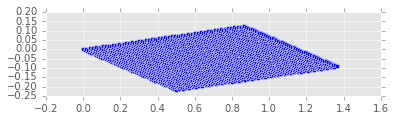

In [19]:
nc.plot()

In [20]:
vg = tools.Variogram(nc,'Y',model=m2)

In [21]:
Sigma = vg.calculateCovarianceMatrix()

In [22]:
from scipy.stats import multivariate_normal as mvn
np.random.seed(12345)
sim1 = mvn.rvs(mean=nc.Y,cov=Sigma)   
n_2 = int(np.sqrt(n))

## Anisotropic Matern simulation for $\kappa$ = 1.5 $\phi$ = 0.16 and angle $\Phi = \frac{\pi}{3}$ and ratio: $\Phi_R = 4$
Using a rotation composed with scaling matrix.

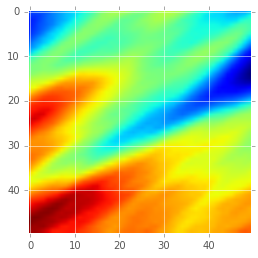

In [23]:
plt.imshow(sim1.reshape(n_2,n_2))

## Now let's do this with affine transformations.
We expect to see the same results. If we use the same parameters. 
Remember that the space of affine transformations is isomorphic to the projection space (except for a point at infinity, I know)

### Remember that the Grid object is a Geodataframe object
Therefore, it has the functions of Geometric Manipulations. (See: http://geopandas.org/geometric_manipulations.html?highlight=affine)

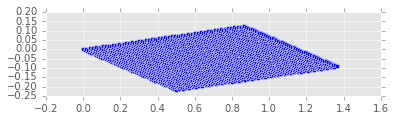

In [24]:
transgrid = grid.geometry.rotate(-phi_A, origin=(0,0),use_radians=True).scale(1,1.0 / phi_R,origin=(0,0))
transgrid.plot()

If you go back (up) to the manually transformed coordinates you will find out that the plot is the same. Except for the argument phi_R that, for the geodataframe object/method (shapely) it should be -phi_R. 
Remmember also to use origin=(something). Without this the method will not work.

In [25]:
grid['transcoords'] = transgrid
grid = grid.set_geometry('transcoords')

In [26]:
grid = grid.set_geometry('transcoords')

## Anisotropic Matern simulation for $\kappa$ = 0.5 $\phi$ = 0.25'  and angle $\Phi = \frac{\pi}{3}$ and ratio: $\Phi_R = 4$

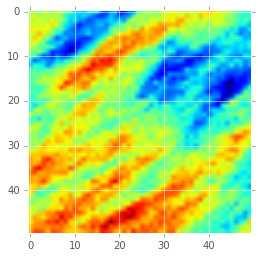

In [27]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m1,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

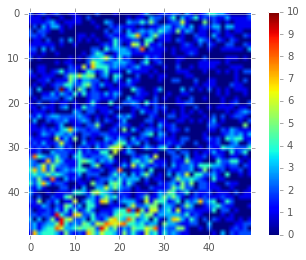

In [28]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

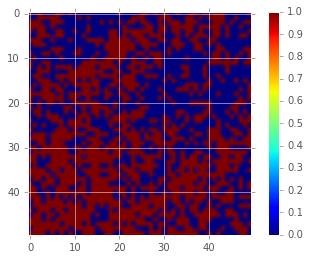

In [29]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

## Anisotropic Matern simulation for $\kappa$ = 1.5 $\phi$ = 0.16 and angle $\Phi = \frac{\pi}{3}$ and ratio: $\Phi_R = 4$

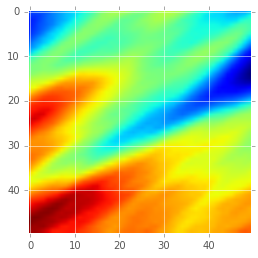

In [30]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m2,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

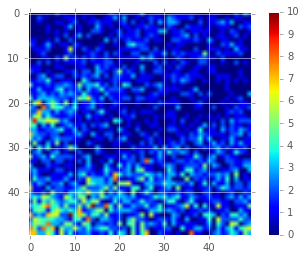

In [31]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

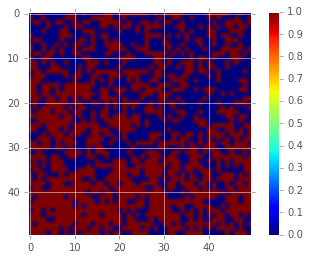

In [32]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

## Anisotropic Matern simulation for $\kappa$ = 2.5 $\phi$ = 0.13 and angle $\Phi = \frac{\pi}{3}$ and ratio: $\Phi_R = 4$

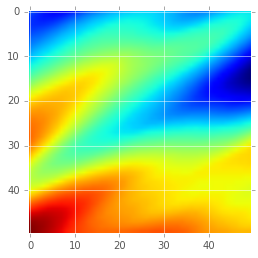

In [33]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m3,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

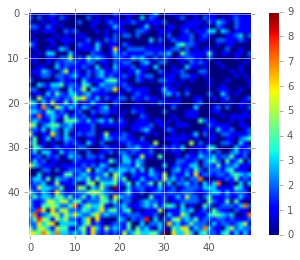

In [34]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

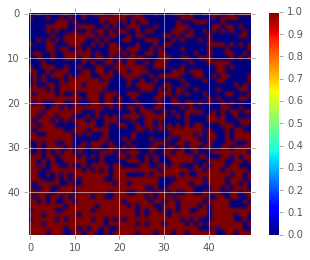

In [35]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

## Experiments skewness in a similar way to anisotrypic modeling

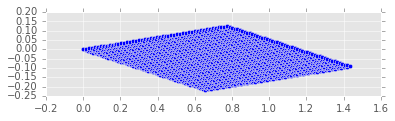

In [36]:
#grid = grid.set_geometry('geometry')
p = np.pi / 5.0
transgrid = grid.geometry.skew(-p,origin=(0,0),use_radians=True)
transgrid.plot()

In [37]:
grid['transcoords'] = transgrid
grid = grid.set_geometry('transcoords')

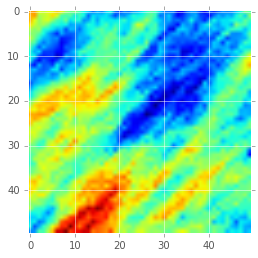

In [38]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m1,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

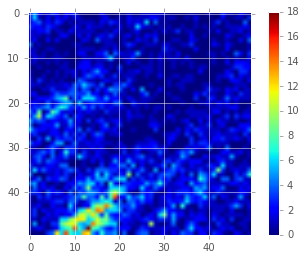

In [39]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

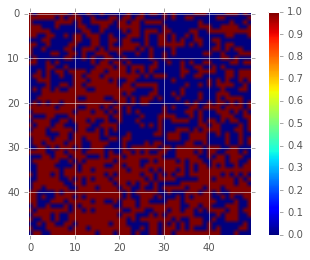

In [40]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

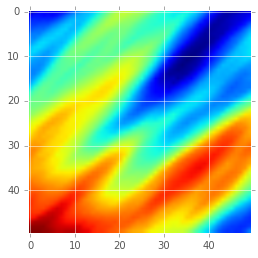

In [41]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m2,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

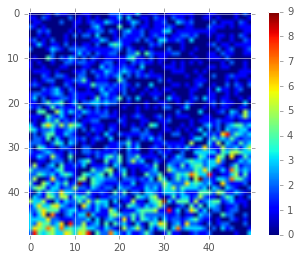

In [42]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

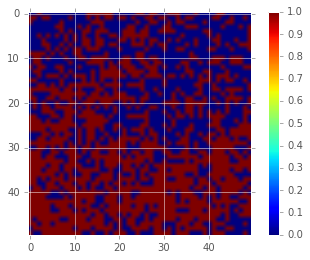

In [43]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

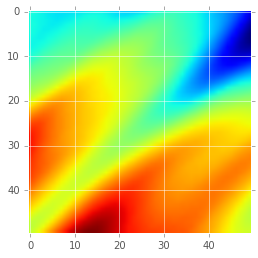

In [44]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m3,random_seed=12345)
plt.imshow(transfield)

### Using the gaussian field as the parameter for a spatially autocorrelated Poisson Process

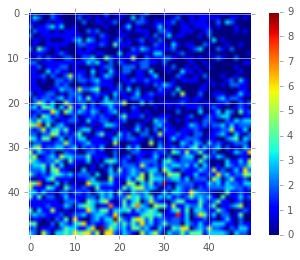

In [45]:
plt.imshow(poisson.rvs(np.exp(transfield),0))
plt.colorbar()

### Using the gaussian field as the parameter for a spatially autocorrelated Bernoulli Process

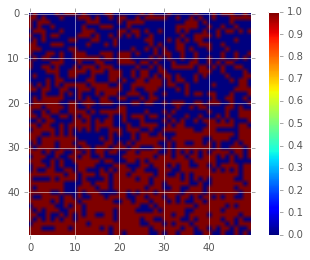

In [46]:
plt.imshow(bernoulli.rvs(expit(transfield),0))
plt.colorbar()

# We can also use non square grids.
In this example we can create a grid with arbitrary x-size and y-size. 
We can plot the results as a scatter plot

In [59]:
## Simulations with non squared grid
grid = tools.createGrid(grid_sizex=50,minx=-1,maxx=2,miny=-1,maxy=2,grid_sizey=70)

### Check the option `return_matrix=False`
This option will return a pandas Dataframe. with the points x,y coordinates (grid) and the simulated values in a column called: `sim`

In [60]:
sim1= tools.simulateGaussianRandomField(grid=grid,variogram_model=m3,random_seed=12345,return_matrix=False)

In [61]:
grid = pd.concat([grid,sim1],axis=1)

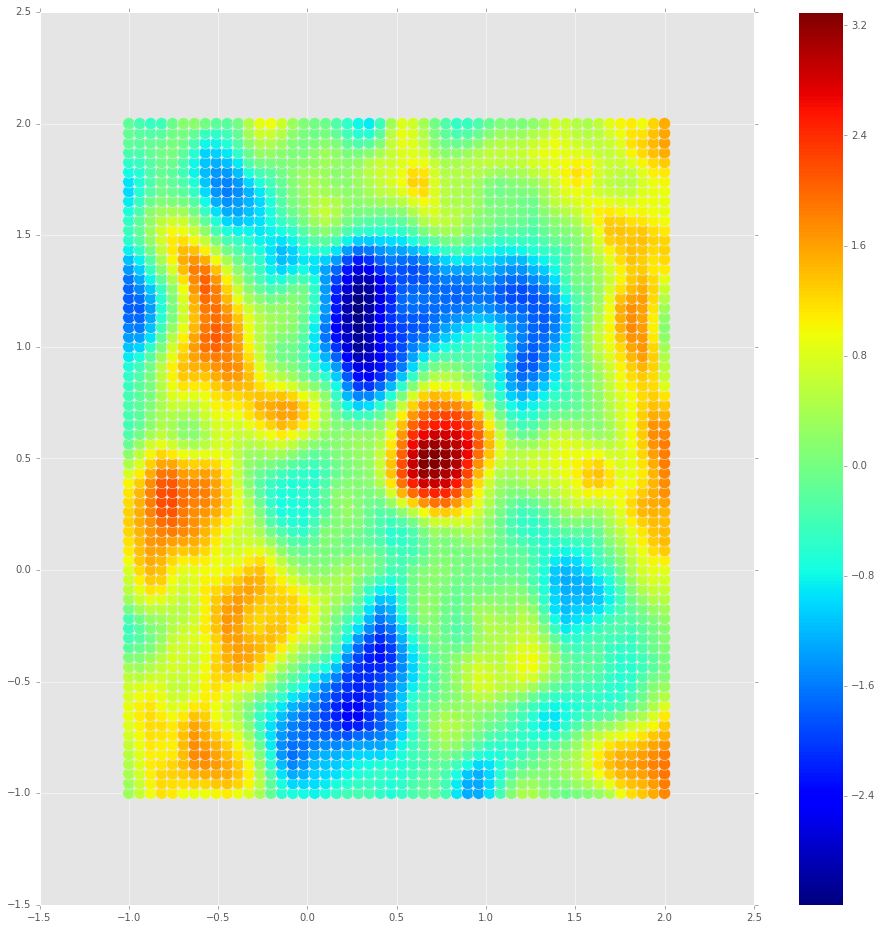

In [63]:
fig = plt.figure(figsize=(16,16), dpi= 80, facecolor='w', edgecolor='w')
#grid.plot(column='sim')
plt.scatter(grid.Lon,grid.Lat,c=grid.sim.values,s=150)
plt.colorbar()

### Plot as a Color Mesh (matplotlib.pcolor) using our special function.

In [64]:
a,b,c = tools.simulatedGaussianFieldAsPcolorMesh(m2,grid_sizex=50,minx=-1,maxx=2,miny=-1,maxy=2,grid_sizey=70)

/apps/external_plugins/spystats/tools.py:485: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sim = sim.sim.reshape(grid_sizey,grid_sizex)


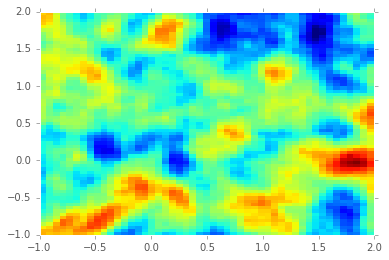

In [77]:
#CS = plt.contour(a,b,c,c='k',lw=2.0)
plt.pcolormesh(a,b,c)


## The same but for poisson data

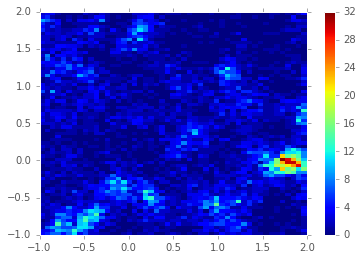

In [83]:
#fig = plt.figure(figsize=(16,16), dpi= 80, facecolor='w', edgecolor='w')
#grid.plot(column='sim')
alpha = 0.01
#CS = plt.contour(a,b,np.exp(c),c='k',lw=2.0)
plt.pcolormesh(a,b,poisson.rvs(np.exp(alpha + c)))

#plt.scatter(grid.Lon,grid.Lat,c=np.exp(alpha + grid.sim),s=150)
plt.colorbar()

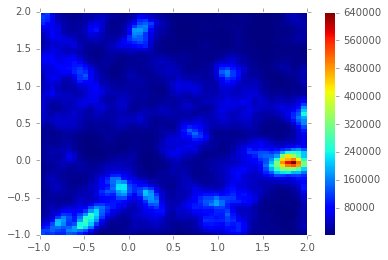

In [82]:
#fig = plt.figure(figsize=(16,16), dpi= 80, facecolor='w', edgecolor='w')
#grid.plot(column='sim')
alpha = 10
#CS = plt.contour(a,b,np.exp(c),c='k',lw=2.0)
plt.pcolormesh(a,b,poisson.rvs(np.exp(alpha + c)))
plt.colorbar()

##  The end hope you enjoyed and encourage you in using *Spystats*